# Příprava dat

In [11]:
import pandas as pd
url = 'https://raw.githubusercontent.com/diezal/OTE_data/main/bg-imbalance-prices-scrape-2025-12-16.csv'
df_ceny_odchylky_bg = pd.read_csv(url)

# 1. Přejmenování sloupce 'valid' na 'date'
df_ceny_odchylky_bg.rename(columns={'valid': 'date'}, inplace=True)

# 2. Převod 'date' na datetime
df_ceny_odchylky_bg['date'] = pd.to_datetime(df_ceny_odchylky_bg['date'], errors='coerce')

# 3. Převod 'price_long' na float
df_ceny_odchylky_bg['price_long'] = pd.to_numeric(df_ceny_odchylky_bg['price_long'], errors='coerce')

# Počet záznamů
n = len(df_ceny_odchylky_bg)

# Přidání periody: opakování 1–96
df_ceny_odchylky_bg['Perioda'] = (list(range(1, 97)) * (n // 96 + 1))[:n]

# Odečti 1 hodinu od všech hodnot ve sloupci 'date'
df_ceny_odchylky_bg['date'] = df_ceny_odchylky_bg['date'] - pd.Timedelta(hours=1)

# Odstranění zbytečných sloupců
df_ceny_odchylky_bg.drop(columns=['country', 'resolution', 'price_short', 'created', 'updated'], inplace=True)
df_ceny_odchylky_bg.rename(columns={'price_long': 'price'}, inplace=True)


df_ceny_odchylky_bg.head()

C:\Users\David Nezval\AppData\Local\Temp\ipykernel_30220\93404050.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_ceny_odchylky_bg['date'] = pd.to_datetime(df_ceny_odchylky_bg['date'], errors='coerce')


,date,price,Perioda
0,2024-07-12 00:00:00,931.67,1
1,2024-07-12 00:14:00,561.10,2
2,2024-07-12 00:30:00,562.12,3
3,2024-07-12 00:45:00,936.19,4
4,2024-07-12 00:59:00,0.00,5


# Vytvoření sloupce s pracovními / nepracovními dny

In [12]:
import holidays

# Bulharské svátky
bg_holidays = holidays.Bulgaria()

# Funkce pro určení pracovního dne
def is_workday(date):
    if pd.isna(date):
        return 0  # NaN jako nepracovní den
    is_weekend = date.weekday() >= 5  # 5 = sobota, 6 = neděle
    is_holiday = date in bg_holidays
    return 0 if is_weekend or is_holiday else 1

# Aplikace funkce
df_ceny_odchylky_bg['pracovni_den'] = df_ceny_odchylky_bg['date'].apply(is_workday)
df_ceny_odchylky_bg.head()

,date,price,Perioda,pracovni_den
0,2024-07-12 00:00:00,931.67,1,1
1,2024-07-12 00:14:00,561.10,2,1
2,2024-07-12 00:30:00,562.12,3,1
3,2024-07-12 00:45:00,936.19,4,1
4,2024-07-12 00:59:00,0.00,5,1


# Vytvoření rozělení podle energetického ročního období /season 

In [19]:
# Funkce pro určení sezóny podle data
def get_season(date):
    if pd.isna(date):
        return None
    month = date.month
    day = date.day

    if (month == 11 or month == 12) or (month == 1 or month == 2) or (month == 3 and day <= 31):
        return "Winter"
    elif (month == 4) or (month == 5):
        return "Shoulder"
    elif (month == 6) or (month == 7) or (month == 8):
        return "Summer"
    elif (month == 9) or (month == 10):
        return "Shoulder"
    else:
        return None  # fallback

# Aplikace funkce na sloupec 'date'
df_ceny_odchylky_bg['season'] = df_ceny_odchylky_bg['date'].apply(get_season)

df_ceny_odchylky_bg.head()

,date,price,Perioda,pracovni_den,season
0,2024-07-12 00:00:00,931.67,1,1,Summer
1,2024-07-12 00:14:00,561.10,2,1,Summer
2,2024-07-12 00:30:00,562.12,3,1,Summer
3,2024-07-12 00:45:00,936.19,4,1,Summer
4,2024-07-12 00:59:00,0.00,5,1,Summer


# Peak / Off-peak

In [24]:
# Funkce pro určení, zda je perioda peak nebo off-peak
def classify_peak(perioda):
    if 33 <= perioda <= 80:
        return 'peak'
    else:
        return 'off-peak'

# Aplikace na DataFrame
df_ceny_odchylky_bg['peak_offpeak'] = df_ceny_odchylky_bg['Perioda'].apply(classify_peak)
df_ceny_odchylky_bg.head()

,date,price,Perioda,pracovni_den,season,peak_offpeak
0,2024-07-12 00:00:00,931.67,1,1,Summer,off-peak
1,2024-07-12 00:14:00,561.10,2,1,Summer,off-peak
2,2024-07-12 00:30:00,562.12,3,1,Summer,off-peak
3,2024-07-12 00:45:00,936.19,4,1,Summer,off-peak
4,2024-07-12 00:59:00,0.00,5,1,Summer,off-peak


# Popisná statistika

In [25]:
# Všechny ceny
all_prices = df_ceny_odchylky_bg['price']

# Ceny podle typu dne
workday_prices = df_ceny_odchylky_bg[df_ceny_odchylky_bg['pracovni_den'] == 1]['price']
non_workday_prices = df_ceny_odchylky_bg[df_ceny_odchylky_bg['pracovni_den'] == 0]['price']

def show_stats(label, series):
    print(f"\n📊 Statistika pro: {label}")
    print(f"Počet hodnot: {series.count()}")
    print(f"Průměrná cena: {series.mean():.2f} BGN/MWh")
    print(f"Medián: {series.median():.2f} BGN/MWh")
    print(f"Min: {series.min():.2f} BGN/MWh")
    print(f"Max: {series.max():.2f} BGN/MWh")
    print(f"Směrodatná odchylka: {series.std():.2f}")


# Výpis statistik
show_stats("✅ Všechny dny", all_prices)
show_stats("🏢 Pracovní dny", workday_prices)
show_stats("🛌 Nepracovní dny (víkend + svátky)", non_workday_prices)

# --- Statistiky podle sezóny ---
seasons = df_ceny_odchylky_bg['season'].dropna().unique()

for season in sorted(seasons):
    season_prices = df_ceny_odchylky_bg[df_ceny_odchylky_bg['season'] == season]['price']
    show_stats(f"🌦️ Sezóna: {season}", season_prices)
    
for peak_type in ['peak', 'off-peak']:
    prices = df_ceny_odchylky_bg[df_ceny_odchylky_bg['peak_offpeak'] == peak_type]['price']
    show_stats(f"⚡ {peak_type.capitalize()}", prices)



📊 Statistika pro: ✅ Všechny dny
Počet hodnot: 50121
Průměrná cena: 188.14 BGN/MWh
Medián: 1.00 BGN/MWh
Min: -1739.03 BGN/MWh
Max: 3057.12 BGN/MWh
Směrodatná odchylka: 313.25

📊 Statistika pro: 🏢 Pracovní dny
Počet hodnot: 34405
Průměrná cena: 191.88 BGN/MWh
Medián: 1.00 BGN/MWh
Min: -1614.74 BGN/MWh
Max: 3057.12 BGN/MWh
Směrodatná odchylka: 324.92

📊 Statistika pro: 🛌 Nepracovní dny (víkend + svátky)
Počet hodnot: 15716
Průměrná cena: 179.95 BGN/MWh
Medián: 1.00 BGN/MWh
Min: -1739.03 BGN/MWh
Max: 1932.16 BGN/MWh
Směrodatná odchylka: 285.88

📊 Statistika pro: 🌦️ Sezóna: Shoulder
Počet hodnot: 17544
Průměrná cena: 184.13 BGN/MWh
Medián: 1.00 BGN/MWh
Min: -1577.78 BGN/MWh
Max: 2603.60 BGN/MWh
Směrodatná odchylka: 308.17

📊 Statistika pro: 🌦️ Sezóna: Summer
Počet hodnot: 13728
Průměrná cena: 175.49 BGN/MWh
Medián: 1.00 BGN/MWh
Min: -1298.34 BGN/MWh
Max: 3057.12 BGN/MWh
Směrodatná odchylka: 310.24

📊 Statistika pro: 🌦️ Sezóna: Winter
Počet hodnot: 18848
Průměrná cena: 201.07 BGN/MWh
Medián

C:\Users\David Nezval\AppData\Local\Temp\ipykernel_30220\2759820245.py:24: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\David Nezval\Desktop\pokus\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


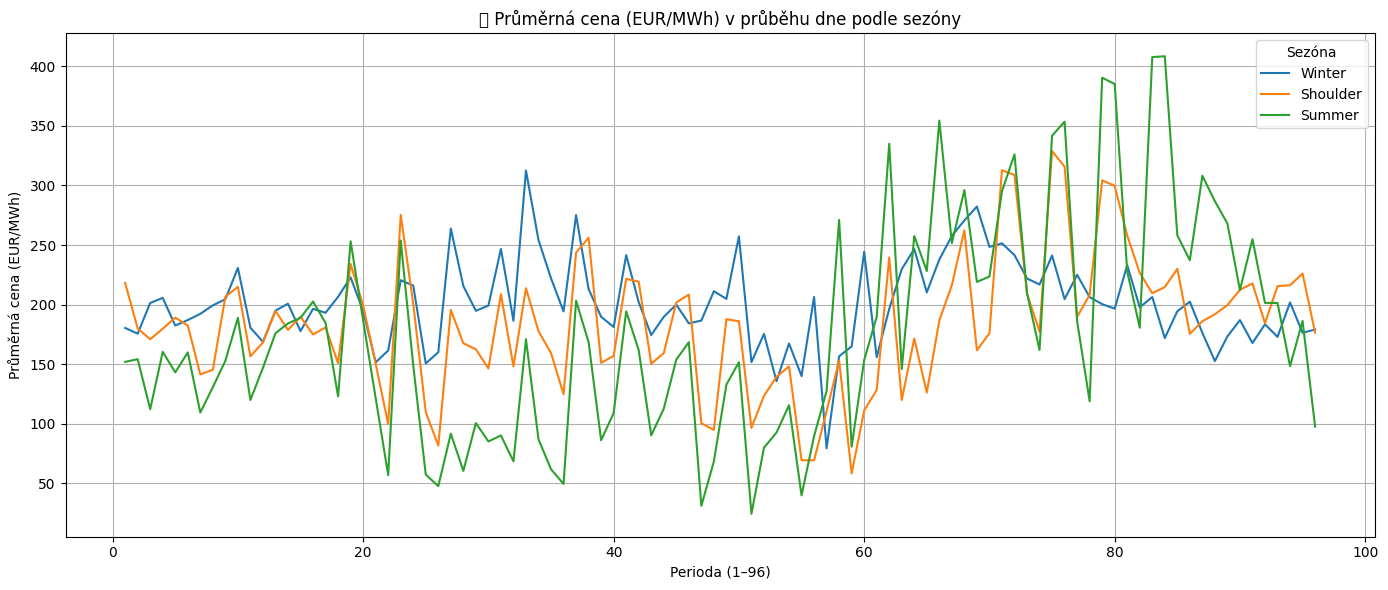

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Nové pořadí sezón pro legendu
season_order = ['Winter', 'Shoulder', 'Summer']

# Výpočet průměrné ceny podle periody a sezóny
avg_price_by_period_season = (
    df_ceny_odchylky_bg
    .groupby(['season', 'Perioda'])['price']
    .mean()
    .reset_index()
)

# Vykreslení grafu
plt.figure(figsize=(14, 6))
sns.lineplot(data=avg_price_by_period_season, x='Perioda', y='price', hue='season', hue_order=season_order)

plt.title('📈 Průměrná cena (EUR/MWh) v průběhu dne podle sezóny')
plt.xlabel('Perioda (1–96)')
plt.ylabel('Průměrná cena (EUR/MWh)')
plt.grid(True)
plt.legend(title='Sezóna')
plt.tight_layout()
plt.show()


C:\Users\David Nezval\AppData\Local\Temp\ipykernel_30220\2349525551.py:24: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\David Nezval\Desktop\pokus\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


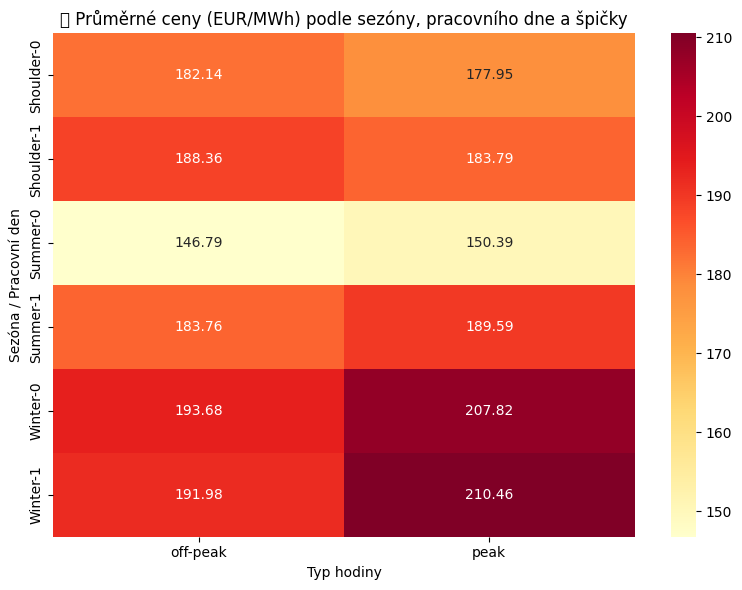

C:\Users\David Nezval\AppData\Local\Temp\ipykernel_30220\2349525551.py:48: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\David Nezval\Desktop\pokus\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


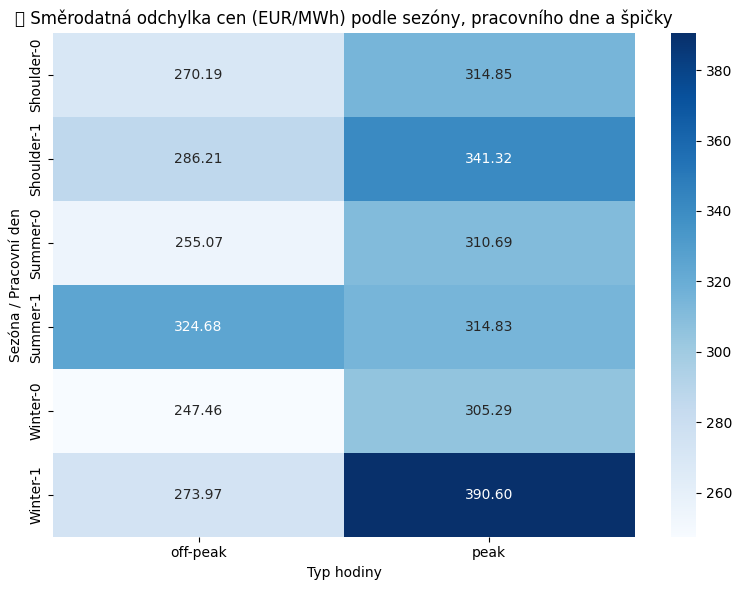

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Vytvoření kontingenční tabulky (pivot tabulky)
pivot = (
    df_ceny_odchylky_bg
    .groupby(['season', 'pracovni_den', 'peak_offpeak'])['price']
    .mean()
    .reset_index()
    .pivot_table(index=['season', 'pracovni_den'], columns='peak_offpeak', values='price')
)

# Převod indexu na MultiIndex pro správné zobrazení
pivot.index = pivot.index.set_names(['Sezóna', 'Pracovní den (1=ano)'])

# Vykreslení heatmapy
plt.figure(figsize=(8, 6))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="YlOrRd")

plt.title('🔥 Průměrné ceny (EUR/MWh) podle sezóny, pracovního dne a špičky')
plt.xlabel('Typ hodiny')
plt.ylabel('Sezóna / Pracovní den')
plt.tight_layout()
plt.show()



# Vytvoření pivot tabulky se směrodatnou odchylkou
pivot_std = (
    df_ceny_odchylky_bg
    .groupby(['season', 'pracovni_den', 'peak_offpeak'])['price']
    .std()
    .reset_index()
    .pivot_table(index=['season', 'pracovni_den'], columns='peak_offpeak', values='price')
)

# Nastavení názvů indexů pro přehlednější popis
pivot_std.index = pivot_std.index.set_names(['Sezóna', 'Pracovní den (1=ano)'])

# Vykreslení heatmapy
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_std, annot=True, fmt=".2f", cmap="Blues")

plt.title('📉 Směrodatná odchylka cen (EUR/MWh) podle sezóny, pracovního dne a špičky')
plt.xlabel('Typ hodiny')
plt.ylabel('Sezóna / Pracovní den')
plt.tight_layout()
plt.show()
